<a href="https://colab.research.google.com/github/ceos-seo/odc-colab/blob/master/notebooks/02.08.02.Colab_S1_Flooding_Large_Region.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentinel-1 Flooding Notebook - Large Region
This notebook uses Sentinel-1 data to detect water extent and flooding over large regions. This is done by using Sentinel-1 data averaged over 100-meter spatial resolution versus the standard 10-meter resolution. Using this approach allows users to search for flooding over very large regions without significant computing time. Once an interesting region is found, users should visit the "S1_Flooding_Detailed_Region" notebook for more detailed studies of flooding extent. 
<br><br>
This notebook includes several different data products including a single date VH-band threshold product to identify water extent, a multi-date change product to identify new flooding, and a time series plot of water extent.
<br><br>
The core data has been processed by Google Earth Engine using GRD scenes to create C-band backscatter (VV and VH bands) at 10-meters spatial resolution. The data is consistently available from early 2017 for the globe. It is important to note that this data does NOT include radiometric terrain correction (RTC) so there are issues using this data in mountaineous areas. In addition, users are recommended to only compare scenes from the same pass direction (ascending or descending) and orbit path to avoid viewing geometry issues. 
<br><br>
<b>NOTE:</b> As of December 23, 2021, the Sentinel-1B mission is not operational. It is unlikely this issue will be resolved, so only one mission (Sentinel-1A) is available. A replacement mission is not likely until 2023.

## Instructions for Execution
It is suggested that users first execute the notebook "as is" to successfully complete the Google authorizations and view sample results. Then, users should look for the following "MODIFY HERE" labels at the top of code blocks to identify code that can be modified. These include:<br>
<br>#1 - Select spatial region and time extent
<br>#2 - Select pixel resolution
<br>#3 - Select data filtering parameters
<br>#4 - Select scene index for single date RGB product
<br>#5 - Select parameters for single date water extent product
<br>#6 - Select parameters for multi-date flooding product
<br><br>
Once the full notebook has been run, users can run individual code blocks using "Shift-Return" or run segments of the code using the Runtime menu. Users do not have to go thru the Google authorization steps for additional execution cycles. 

In [ ]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

In [ ]:
from odc_colab import populate_db
populate_db()

## Load the Data Cube Configuration and Import Utilities

In [ ]:
# Ignore warnings 
import warnings
warnings.simplefilter('ignore')

# Load Data Cube Configuration
from odc_gee.earthengine import Datacube
dc = Datacube()

# Import Utilities
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.dc_rgb import rgb
from utils.data_cube_utilities.raster_filter import stats_filter_2d
import folium
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Select data platform and product
# NOTE: Data from both Sentinel-1A and Sentinel-1B missions are included
platform = 'Sentinel-1A'
product = 's1_google'

## Define the Extents of the Analysis and View
Select the center of an analysis region (lat_long) below. The size of the region (in degrees) that surrounds this center point is defined using the "box_size_deg" parameter. Use the map output to zoom in-or-out to find other regions. Click on the map to find a Lat-Lon position. After selecting an analysis region, you can also select a time window by defining the start date and end date for the "time_extents" parameter. Consistent Sentinel-1 time series data is available from Jan-2017. 

In [5]:
#1 MODIFY HERE

# This is a sample region over Tabasco, Mexico that is prone to flooding
# A severe flooding event occurred between Sept-2020 and Feb-2021
# Orbit 99 is suggested for image comparisons to yield good results

lat_long = (18.0, -92.67)
box_size_deg = 1.0
time_extents = ('2020-09-01', '2021-02-01')

In [6]:
# Calculate the latitude and longitude bounds of the analysis box
latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

In [7]:
f = folium.Figure(width=800, height=800)
m = display_map(latitude,longitude)
f.add_child(m)

## Load the data

In [8]:
#2 MODIFY HERE

# Loading large amounts of data using resampling
# Requires averaging pixels and changing the output resolution
# Baseline Sentinel-1 resolution = 10 meters per pixel
# New resolution for large-scale analyses = 100 meters per pixel

# resolution > desired output pixel resolution after resampling
# scale > conversion of resolution to degrees (assumes 111320 m/deg at equator)

resolution = 100
scale = resolution / 111320.0 

# Add the following parameters to the dc.load command for resampling
# output_crs='EPSG:4326', resolution=(-scale, scale), resampling='average'

In [9]:
#3 MODIFY HERE

# This section will load the data for analysis
# It is possible to view all possible data (ALL DATA) or filter for specific data (FILTERED DATA)

########################

# ALL DATA
# This parameter list will load all data (both pass directions, both missions, all orbits)
# group_by = 'time' (all images separated) or 'solar_day' (grouped daily)
# Use this output to review available data before adding further filters (below)

# parameters = dict(product=product, platform=platform, measurements=[ ],time=time_extents, lat=latitude, lon=longitude, group_by='solar_day',output_crs='EPSG:4326', resolution=(-scale, scale), resampling='average')

########################

# FILTERED DATA
# Add any combination of query filters after "group_by" in the parameters list

# orbitProperties_pass = ASCENDING or DESCENDING
# EXAMPLE > query={'filter':'orbitProperties_pass="ASCENDING"'}

# relativeOrbitNumber_start = (any specific orbit number)
# EXAMPLE > query={'filter':'relativeOrbitNumber_start=62'}

# platform_number = A or B
# EXAMPLE > query={'filter':'platform_number="A"'}

# Combined filter using several parameters
# EXAMPLE > query={'filter':'platform_number="A" AND relativeOrbitNumber_start=136'}

# Example Case - Uses orbit #99
parameters = dict(product=product, platform=platform, measurements=['vv','vh'],
                  time=time_extents, lat=latitude, lon=longitude, group_by='solar_day',
                  output_crs='EPSG:4326', resolution=(-scale, scale), resampling='average',
                 query={'filter':'relativeOrbitNumber_start=99'})

In [10]:
# Load the data and report the CPU and clock time
# NOTE: This step may take 20+ minutes
%%time
sar_dataset = dc.load(**parameters)

CPU times: user 1min 2s, sys: 16.5 s, total: 1min 18s
Wall time: 1h 4min 13s


In [11]:
# Filter Metadata

from operator import itemgetter

def get_metadata(group):
    metadata = (set(), set(), set(), set())
    for ds in group:
        metadata[0].add(np.datetime64(ds.metadata_doc.get('properties').get('dtr:start_datetime'), 'D'))
        metadata[1].add(ds.metadata_doc.get('properties').get('gee:properties').get('orbitProperties_pass'))
        metadata[2].add(ds.metadata_doc.get('properties').get('gee:properties').get('platform_number'))
        metadata[3].add(ds.metadata_doc.get('properties').get('gee:properties').get('relativeOrbitNumber_start'))
    return tuple(map(lambda x: ', '.join([str(i) for i in x]), metadata))

parameters.update(group_by='time' if not parameters.get('group_by') else parameters['group_by'])
sar_metadata = sorted([get_metadata(groups)
                       for groups in dc.group_datasets(dc.find_datasets(**parameters),
                                                       parameters.get('group_by')).values],
                      key=itemgetter(0))

## Data Summary
The table below summarizes the available Sentinel-1 data. You will find different acquisition dates, pass directions (ascending or descending), missions (A=Sentinel-1A, B=Sentinel-1B) and orbit path numbers. Finding flooding requires comparisons of images from similar viewing angles. So, it is important to only compare acquisitions with the same orbit path number. You will find that the same orbit number can come from two missions (6-day separation) or one mission (12-day separation) but the pass direction (ascending or descending) will be the same. 

In [12]:
# Show acquisition indices and dates
pd.set_option('display.max_rows', 250)
pd.DataFrame(sar_metadata, columns=['Acquisition Date', 'Pass Direction', 'Mission', 'Orbit Number'])

,Acquisition Date,Pass Direction,Mission,Orbit Number
0,2020-09-04,DESCENDING,B,99
1,2020-09-10,DESCENDING,A,99
2,2020-09-16,DESCENDING,B,99
3,2020-09-22,DESCENDING,A,99
4,2020-09-28,DESCENDING,B,99
5,2020-10-04,DESCENDING,A,99
6,2020-10-10,DESCENDING,B,99
7,2020-10-16,DESCENDING,A,99
8,2020-10-22,DESCENDING,B,99
9,2020-11-03,DESCENDING,B,99


## Scale the backscatter amplitude for better image outputs
Backscatter amplitude for each band can be scaled to an 8-bit range of 0-255 to improve visual output and maximize contrast in image products. This process is explained here. Sigma-nought backscatter (in dB units) is converted to linear amplitude (digital number) units using the conversion: DN (amplitude) = 10^(dB/20). Histograms are then used to view the range of dB values for the VV and VH bands. The range of expected values (across diverse land types) is then scaled to an 8-bit range using the formula: Scale = 256 / (range). Finally, an "offset" value is applied to allow the full range of values to be distributed across the 8-bit range. The final conversion equation is: DN (amplitude, 8-bit) = ( DN(amplitude) - offset ) * scale. 

In [13]:
# This backscatter scaling is optimized for block-filtered data
# VV band range is 0dB to -16dB which is DN=1.00 to DN=0.158
# VH band range is -5dB to -27dB which is DN=0.562 to DN=0.045
# VV/VH range is 0.0 to 1.0. This data is scaled by 20 for improved color contrast

vv_convert = (10**(sar_dataset.vv/20)-0.158)*303
vh_convert = (10**(sar_dataset.vh/20)-0.045)*493
sar_dataset['vv_amp'] = vv_convert
sar_dataset['vh_amp'] = vh_convert
sar_dataset['vvvh_amp'] = (vv_convert / vh_convert) * 20

RGB False-Color Image of Backscatter Intensity

In [14]:
#4 MODIFY HERE

# Choose a single time slice by its index (listed above)
index_to_show = 0

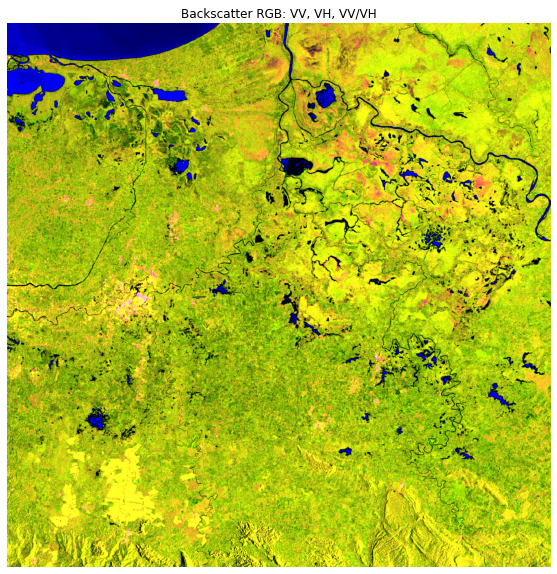

In [15]:
# RGB Plot of Backscatter Intensity (RGB= VV, VH, VV/VH)
# High backscatter (both bands) due to vegetation and foliage will appear as YELLOW (mix of red and green)
# Urban areas are BRIGHT YELLOW or MAGENTA in color (due to high overall scattering at both VV and VH, 
# or, in the case of the magenta color, higher VV compared to VH)
# Sparsely vegetated and bare soil areas are BLUE (due to low overall scattering and higher VV compared to VH)
# Water (without wind or rain effects) is BLACK (very low backscatter in both bands with similar VV and VH)

rgb(sar_dataset.isel(time=index_to_show),bands=['vv_amp','vh_amp','vvvh_amp'], width=10)
plt.title('Backscatter RGB: VV, VH, VV/VH')
plt.axis('off')
plt.show()

## Single Date Single-Band Threshold Water Extent
The code below allows users to select a single date (use the index table above), a single band (e.g. VV or VH), and a water detection threshold value for the selected band. Review the histogram plots above to be sure the selected band and threshold are reasonable. It is common to use the VH band for water detection. The final product shows the water in BLUE color against a gray-scale VH-band background image. 

In [16]:
#5 MODIFY HERE

# Select a single date, band, and threshold for water detection

single_date = 0
single_variable = 'vh'
water_threshold = -23.0

In [17]:
color_blue = np.array([0,0,255]) # Water (BLUE)
scene = sar_dataset.isel(time=single_date)
water = scene[single_variable].values < water_threshold

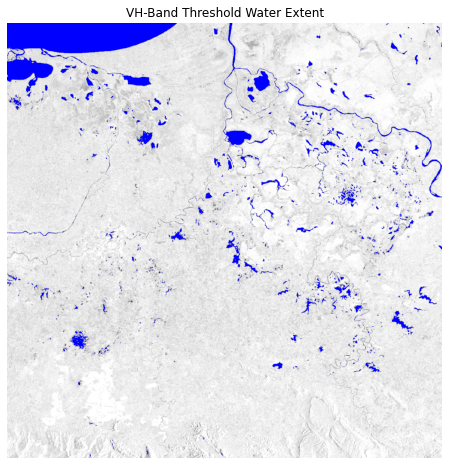

In [18]:
rgb(scene, bands=['vh', 'vh', 'vh'], paint_on_mask=[(water, color_blue)], width=8, min_inten=0.6)
plt.title('VH-Band Threshold Water Extent')
plt.axis('off')
plt.show()

## Multi-Date Single-Band Threshold Flooding
The code below selects two dates, a variable (VV or VH) and a change threshold. The final product performs a comparison of the two dates and calculates the change in backscatter between those dates. Pixels with significant reduction in backscatter (e.g., loss of 7 dB) are likely changes from land to water due to flooding. Finding flooding requires comparisons of images from similar viewing angles. So, it is important to only compare acquisitions with the same orbit number. You will find that the same orbit number can come from two missions (6-day separation) or one mission (12-day separation) but the pass direction (ascending or descending) will be the same. 

In [19]:
#6 MODIFY HERE

# Select TWO acquisitions to calculate a change product
# Choose from the indices in the table above
# first_acq_ind = First time slice acquisition
# second_acq_ind = Second time slice acquisition

first_acq_ind = 0
second_acq_ind = 7

In [20]:
# Select the variable to plot: vv or vh

threshold_variable = 'vh'

# The code will calculate the difference of the two images (Second-First)
# Define a threshold range to compare the difference of the two acquisitions
# GREY = Pixels NOT in the threshold range 
# RED = Pixels LESS than the low end of the threshold range

change_threshold = -7

In [21]:
# Set the overlay colors
# Calculate the difference in backscatter between the two times
# Find the pixels above or below the threshold range (these are significant changes)

color_loss = np.array([255,0,0]) # backscatter decrease (RED)
color_black = np.array([0,0,0]) # low backscatter change, water (BLACK)
color_blue = np.array([0,0,255]) # Water (BLUE)

first_acq = sar_dataset.isel(time=first_acq_ind)
second_acq = sar_dataset.isel(time=second_acq_ind)
change_product = second_acq[threshold_variable] - first_acq[threshold_variable]
below_threshold = change_product.values < change_threshold

In [22]:
# Set the water threshold value based on data in the histograms for the selected band
# This will "mask" the water pixels in the first acquisition

water = first_acq[threshold_variable].values < water_threshold

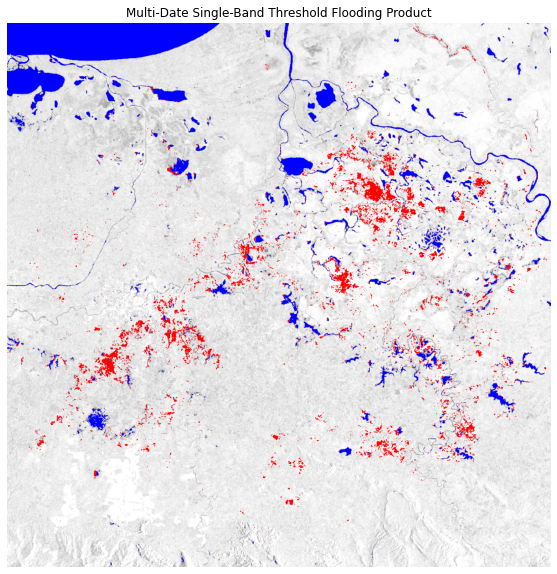

In [23]:
# Create a custom threshold plot to identify flooding
# The background image VV backscatter (grey-scale)
# RED areas have decreased backscatter indicative of new flooding
# BLACK areas are water in the first acquisition 

rgb(first_acq, bands=['vh', 'vh', 'vh'], paint_on_mask=[(below_threshold, color_loss),(water, color_blue)], width=10, min_inten=0.6)
plt.title('Multi-Date Single-Band Threshold Flooding Product')
plt.axis('off')
plt.show()

In [24]:
from utils.data_cube_utilities.dc_display_map import display_map

loss_layer = np.dstack([below_threshold.astype(np.int8)*c \
                        for c in color_loss]+[below_threshold.astype(np.int8)])
water_layer = np.dstack([water.astype(np.int8)*c \
                         for c in color_blue]+[water.astype(np.int8)])

_map = display_map(latitude, longitude)
_map.add_child(folium.TileLayer(tiles='OpenStreetMap', name='OpenStreetMap'))
_map.add_child(folium.TileLayer(tiles='https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png',
                                max_zoom=17,
                                attr='Map data: &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, <a href="http://viewfinderpanoramas.org">SRTM</a> | Map style: &copy; <a href="https://opentopomap.org">OpenTopoMap</a> (<a href="https://creativecommons.org/licenses/by-sa/3.0/">CC-BY-SA</a>)',
                                name='OpenTopoMap'))
_map.add_child(folium.raster_layers.ImageOverlay(loss_layer, [(latitude[0], longitude[0]),
                                                              (latitude[1], longitude[1])], name='Flooding'))
_map.add_child(folium.raster_layers.ImageOverlay(water_layer, [(latitude[0], longitude[0]),
                                                              (latitude[1], longitude[1])], name='Water'))
_map.add_child(folium.LayerControl())

## Plot the Time Series Water Extent
This output product uses data from the entire time series

In [27]:
water_time = ((sar_dataset[single_variable] < water_threshold))

In [28]:
out = []
for obj in water_time:
    total = obj.values.sum()*100/1000/1000
    day = [total]
    out.append(day)

In [29]:
water_pixels = out
scene = sar_dataset.time.dt.date.values

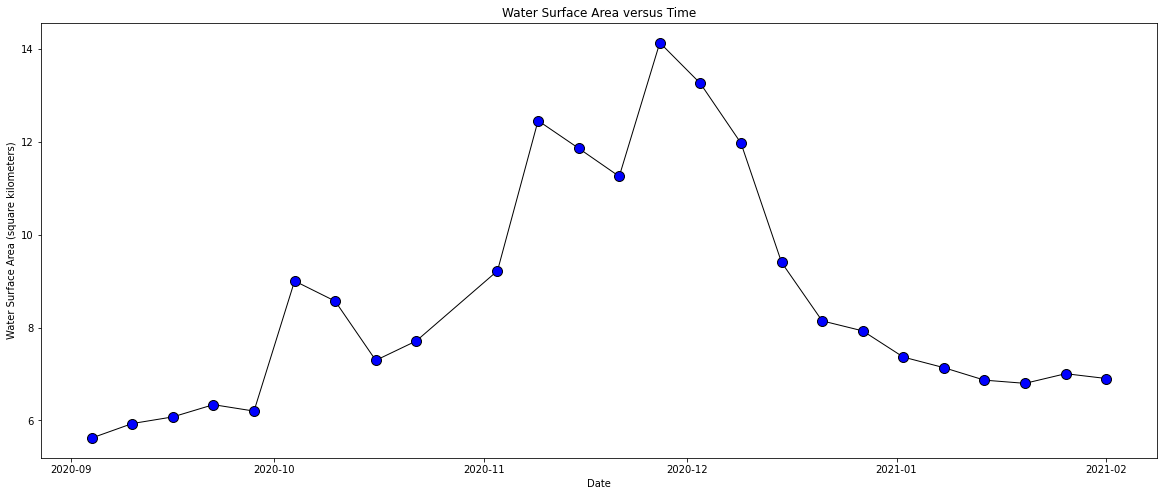

In [30]:
plt.figure(figsize=(20,8))
plt.plot(scene, water_pixels, c='black', marker='o', mfc='blue', markersize=10, linewidth=1)
plt.title('Water Surface Area versus Time')
plt.xlabel('Date')
plt.ylabel('Water Surface Area (square kilometers)')
plt.show()